# LightGBM

### Parametry:

* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
    
* **attributes**
    * **hp**
    * **ac**
    * **perception**
* **saves**
    * **fortitude**
    * **reflex**
    * **will**
* **resources**
    * **focus**

### Przewidujemy: *level*

In [28]:
# !pip install lightgbm==3.3.1 numpy optuna==3.3.0 scikit-learn --user

## Loading data

In [29]:
import pandas as pd
import numpy as np
import sys

import os
import pathlib

sys.path.append("../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=[
        "cha",
        "con",
        "dex",
        "int",
        "str",
        "wis",
        "ac",
        "hp",
        "perception",
        "fortitude",
        "reflex",
        "will",
        "focus",
    ],
)

c:\users\pauli\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [30]:
print(df.head())

   cha  con  dex  int  str  wis  ac   hp  perception  fortitude  reflex  will  \
0    1    5    2    1    7    2  29  215          20         22      19    17   
1    1    5    0   -4    9    2  28  220          16         21      14    16   
2   -2    6    3   -4    7    3  25  175          17         20      17    15   
3    6    5    4    6    7    5  41  315          30         30      29    32   
4    1    1    3   -1   -5    1  16   20           6          6      10     4   

   focus                 book  level  
0      1  Pathfinder Bestiary     10  
1      0  Pathfinder Bestiary     10  
2      0  Pathfinder Bestiary      8  
3      1  Pathfinder Bestiary     17  
4      1  Pathfinder Bestiary      1  


## Train test split

### Chronological split

In [31]:
from training.splitting_dataset import split_dataframe
import os

os.chdir("../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models")

In [32]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

### <span style="color:red">Z jakiegos powodu X_train i y_train ma typy object zamiast int64. Naprawiłabym to w funkcji albo chociaż zrzutowała na inta.</span>

In [33]:
print(X_train.info())
print(X_test.info())
print(y_train.head())
print(y_test.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 841 entries, 0 to 840
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   cha         841 non-null    object
 1   con         841 non-null    object
 2   dex         841 non-null    object
 3   int         841 non-null    object
 4   str         841 non-null    object
 5   wis         841 non-null    object
 6   ac          841 non-null    object
 7   hp          841 non-null    object
 8   perception  841 non-null    object
 9   fortitude   841 non-null    object
 10  reflex      841 non-null    object
 11  will        841 non-null    object
 12  focus       841 non-null    object
dtypes: object(13)
memory usage: 92.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 365 entries, 841 to 1205
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   cha         365 non-null    int64
 1   con         365 no

In [34]:
X_train = X_train.astype("int64")
y_train = y_train.astype("int64")

### Random split

In [35]:
from training.splitting_dataset import split_dataframe

(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [36]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## LightGBM

### With chronological split

In [37]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=20,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

y_pred_train = gbm.predict(X_train, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test, num_iteration=gbm.best_iteration)


mse = mean_squared_error(y_test, y_pred_test)
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 379
[LightGBM] [Info] Number of data points in the train set: 841, number of used features: 13
[LightGBM] [Info] Start training from score 6.966706
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[20]	valid_0's l1: 0.791551	valid_0's l2: 0.97348
MSE: 0.97
RMSE: 0.99


Without tuning results are not that great.

### With random split

In [38]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)
lgb_eval = lgb.Dataset(X_test_random_split, y_test_random_split, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

y_pred_train_random_split = gbm.predict(
    X_train_random_split, num_iteration=gbm.best_iteration
)
y_pred_test_random_split = gbm.predict(
    X_test_random_split, num_iteration=gbm.best_iteration
)


mse = mean_squared_error(y_test_random_split, y_pred_test_random_split)
rmse = mean_squared_error(y_test_random_split, y_pred_test_random_split, squared=False)
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 392
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 13
[LightGBM] [Info] Start training from score 7.162611
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[88]	valid_0's l1: 0.267273	valid_0's l2: 0.148111
MSE: 0.15
RMSE: 0.38


## Tuning

In [39]:
import lightgbm as lgb

print(lgb.__version__)
import optuna as lgb

print(lgb.__version__)

3.3.1
3.3.0


### With chronological split

In [40]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train, y_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-08-07 21:52:16,365] A new study created in memory with name: no-name-5b2208fe-b0cf-4c42-9de5-198c8d1b9c50
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.189405 + 0.0383498
[200]	cv_agg's l2: 0.18619 + 0.0363794
[300]	cv_agg's l2: 0.185643 + 0.0359882


feature_fraction, val_score: 0.185452:  14%|######4                                      | 1/7 [00:01<00:07,  1.30s/it]

Early stopping, best iteration is:
[260]	cv_agg's l2: 0.185452 + 0.0359388
[100]	cv_agg's l2: 0.16153 + 0.0200527


feature_fraction, val_score: 0.159583:  29%|############8                                | 2/7 [00:02<00:04,  1.04it/s]

[200]	cv_agg's l2: 0.160334 + 0.0179611
Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179
[100]	cv_agg's l2: 0.179497 + 0.0373779


feature_fraction, val_score: 0.159583:  43%|###################2                         | 3/7 [00:02<00:03,  1.06it/s]

[200]	cv_agg's l2: 0.175488 + 0.034751
Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179
[100]	cv_agg's l2: 0.164856 + 0.0191397


feature_fraction, val_score: 0.159583:  57%|#########################7                   | 4/7 [00:03<00:02,  1.15it/s]

[200]	cv_agg's l2: 0.16266 + 0.0182879
Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179
[100]	cv_agg's l2: 0.177436 + 0.0335523


feature_fraction, val_score: 0.159583:  71%|################################1            | 5/7 [00:04<00:01,  1.18it/s][I 2023-08-07 21:52:20,872] Trial 4 finished with value: 0.17481036692174237 and parameters: {'feature_fraction': 0.8}. Best is trial 1 with value: 0.15958330323222156.


[200]	cv_agg's l2: 0.175023 + 0.0316317
Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179


feature_fraction, val_score: 0.159583:  71%|################################1            | 5/7 [00:04<00:01,  1.18it/s]

[100]	cv_agg's l2: 0.166689 + 0.0187719


feature_fraction, val_score: 0.159583:  71%|################################1            | 5/7 [00:05<00:01,  1.18it/s]

[200]	cv_agg's l2: 0.16294 + 0.0182487
Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179


feature_fraction, val_score: 0.159583:  86%|######################################5      | 6/7 [00:05<00:00,  1.17it/s]

[100]	cv_agg's l2: 0.167078 + 0.0232235


feature_fraction, val_score: 0.159583: 100%|#############################################| 7/7 [00:06<00:00,  1.13it/s]


[200]	cv_agg's l2: 0.165981 + 0.0231724
Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179


num_leaves, val_score: 0.159583:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.16153 + 0.0200527


num_leaves, val_score: 0.159583:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[200]	cv_agg's l2: 0.160334 + 0.0179611
Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179


num_leaves, val_score: 0.159583:   5%|##5                                               | 1/20 [00:00<00:16,  1.17it/s]

[100]	cv_agg's l2: 0.16153 + 0.0200527


num_leaves, val_score: 0.159583:  10%|#####                                             | 2/20 [00:01<00:14,  1.21it/s]

[200]	cv_agg's l2: 0.160334 + 0.0179611
Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179
[100]	cv_agg's l2: 0.16153 + 0.0200527
[200]	cv_agg's l2: 0.160334 + 0.0179611
Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179


num_leaves, val_score: 0.159583:  15%|#######5                                          | 3/20 [00:02<00:13,  1.26it/s]

[100]	cv_agg's l2: 0.16153 + 0.0200527


num_leaves, val_score: 0.159583:  20%|##########                                        | 4/20 [00:03<00:12,  1.25it/s]

[200]	cv_agg's l2: 0.160334 + 0.0179611
Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179
[100]	cv_agg's l2: 0.16153 + 0.0200527


num_leaves, val_score: 0.159583:  25%|############5                                     | 5/20 [00:04<00:12,  1.24it/s]

[200]	cv_agg's l2: 0.160334 + 0.0179611
Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179
[100]	cv_agg's l2: 0.16153 + 0.0200527
[200]	cv_agg's l2: 0.160334 + 0.0179611
Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179


num_leaves, val_score: 0.159583:  30%|###############                                   | 6/20 [00:04<00:11,  1.21it/s]

[100]	cv_agg's l2: 0.16153 + 0.0200527


num_leaves, val_score: 0.159583:  35%|#################5                                | 7/20 [00:05<00:10,  1.21it/s]

[200]	cv_agg's l2: 0.160334 + 0.0179611
Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179
[100]	cv_agg's l2: 0.179623 + 0.0257906
[200]	cv_agg's l2: 0.168283 + 0.0221837
Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179

num_leaves, val_score: 0.159583:  40%|####################                              | 8/20 [00:06<00:08,  1.48it/s]


[100]	cv_agg's l2: 0.16153 + 0.0200527


num_leaves, val_score: 0.159583:  40%|####################                              | 8/20 [00:06<00:08,  1.48it/s]

[200]	cv_agg's l2: 0.160334 + 0.0179611
Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179


num_leaves, val_score: 0.159583:  45%|######################5                           | 9/20 [00:06<00:07,  1.40it/s]

[100]	cv_agg's l2: 0.16153 + 0.0200527
[200]	cv_agg's l2: 0.160334 + 0.0179611
Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179


num_leaves, val_score: 0.159583:  50%|########################5                        | 10/20 [00:07<00:07,  1.35it/s]

[100]	cv_agg's l2: 0.16153 + 0.0200527
[200]	cv_agg's l2: 0.160334 + 0.0179611
Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179

num_leaves, val_score: 0.159583:  55%|##########################9                      | 11/20 [00:08<00:07,  1.27it/s]


[100]	cv_agg's l2: 0.16153 + 0.0200527


num_leaves, val_score: 0.159583:  60%|#############################4                   | 12/20 [00:09<00:06,  1.26it/s]

[200]	cv_agg's l2: 0.160334 + 0.0179611
Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179
[100]	cv_agg's l2: 0.16153 + 0.0200527


num_leaves, val_score: 0.159583:  65%|###############################8                 | 13/20 [00:10<00:05,  1.29it/s]

[200]	cv_agg's l2: 0.160334 + 0.0179611
Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179
[100]	cv_agg's l2: 0.16153 + 0.0200527


num_leaves, val_score: 0.159583:  70%|##################################3              | 14/20 [00:10<00:04,  1.30it/s]

[200]	cv_agg's l2: 0.160334 + 0.0179611
Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179
[100]	cv_agg's l2: 0.16153 + 0.0200527


num_leaves, val_score: 0.159583:  75%|####################################7            | 15/20 [00:11<00:03,  1.29it/s]

[200]	cv_agg's l2: 0.160334 + 0.0179611
Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179
[100]	cv_agg's l2: 0.16153 + 0.0200527


num_leaves, val_score: 0.159583:  80%|#######################################2         | 16/20 [00:12<00:03,  1.30it/s]

[200]	cv_agg's l2: 0.160334 + 0.0179611
Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179
[100]	cv_agg's l2: 0.16153 + 0.0200527


num_leaves, val_score: 0.159583:  85%|#########################################6       | 17/20 [00:13<00:02,  1.29it/s]

[200]	cv_agg's l2: 0.160334 + 0.0179611
Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179
[100]	cv_agg's l2: 0.16153 + 0.0200527


num_leaves, val_score: 0.159583:  90%|############################################1    | 18/20 [00:14<00:01,  1.28it/s]

[200]	cv_agg's l2: 0.160334 + 0.0179611
Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179
[100]	cv_agg's l2: 0.16153 + 0.0200527


num_leaves, val_score: 0.159583:  95%|##############################################5  | 19/20 [00:14<00:00,  1.29it/s]

[200]	cv_agg's l2: 0.160334 + 0.0179611
Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179
[100]	cv_agg's l2: 0.16153 + 0.0200527


num_leaves, val_score: 0.159583: 100%|#################################################| 20/20 [00:15<00:00,  1.29it/s]


[200]	cv_agg's l2: 0.160334 + 0.0179611
Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179


bagging, val_score: 0.159583:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.178338 + 0.0200559


bagging, val_score: 0.159583:  10%|#####3                                               | 1/10 [00:00<00:05,  1.55it/s]

[200]	cv_agg's l2: 0.170192 + 0.0147541
Early stopping, best iteration is:
[152]	cv_agg's l2: 0.159583 + 0.0182179
[100]	cv_agg's l2: 0.159846 + 0.0197405


bagging, val_score: 0.157493:  20%|##########6                                          | 2/10 [00:01<00:05,  1.37it/s]

[200]	cv_agg's l2: 0.157939 + 0.0172474
Early stopping, best iteration is:
[143]	cv_agg's l2: 0.157493 + 0.0175755
[100]	cv_agg's l2: 0.161852 + 0.0202667


bagging, val_score: 0.157493:  30%|###############9                                     | 3/10 [00:02<00:05,  1.33it/s]

[200]	cv_agg's l2: 0.161898 + 0.0192496
Early stopping, best iteration is:
[143]	cv_agg's l2: 0.157493 + 0.0175755
[100]	cv_agg's l2: 0.164692 + 0.0227104


bagging, val_score: 0.157493:  40%|#####################2                               | 4/10 [00:03<00:04,  1.29it/s]

[200]	cv_agg's l2: 0.163123 + 0.0214697
Early stopping, best iteration is:
[143]	cv_agg's l2: 0.157493 + 0.0175755
[100]	cv_agg's l2: 0.223783 + 0.0129689
[200]	cv_agg's l2: 0.207573 + 0.00975695


bagging, val_score: 0.157493:  50%|##########################5                          | 5/10 [00:03<00:03,  1.52it/s]

Early stopping, best iteration is:
[143]	cv_agg's l2: 0.157493 + 0.0175755
[100]	cv_agg's l2: 0.165189 + 0.0226692


bagging, val_score: 0.157493:  60%|###############################8                     | 6/10 [00:04<00:02,  1.46it/s]

[200]	cv_agg's l2: 0.159733 + 0.0174892
Early stopping, best iteration is:
[143]	cv_agg's l2: 0.157493 + 0.0175755
[100]	cv_agg's l2: 0.173283 + 0.0176621


bagging, val_score: 0.157493:  70%|#####################################                | 7/10 [00:04<00:02,  1.45it/s]

[200]	cv_agg's l2: 0.170425 + 0.011147
Early stopping, best iteration is:
[143]	cv_agg's l2: 0.157493 + 0.0175755
[100]	cv_agg's l2: 0.162896 + 0.02102


bagging, val_score: 0.157493:  80%|##########################################4          | 8/10 [00:05<00:01,  1.43it/s]

[200]	cv_agg's l2: 0.158771 + 0.0200503
Early stopping, best iteration is:
[143]	cv_agg's l2: 0.157493 + 0.0175755
[100]	cv_agg's l2: 0.181828 + 0.0178037


bagging, val_score: 0.157493:  90%|###############################################7     | 9/10 [00:06<00:00,  1.45it/s]

[200]	cv_agg's l2: 0.174871 + 0.0166129
Early stopping, best iteration is:
[143]	cv_agg's l2: 0.157493 + 0.0175755
[100]	cv_agg's l2: 0.163847 + 0.0185997


bagging, val_score: 0.157493: 100%|####################################################| 10/10 [00:07<00:00,  1.40it/s]


[200]	cv_agg's l2: 0.160193 + 0.01654
Early stopping, best iteration is:
[143]	cv_agg's l2: 0.157493 + 0.0175755


feature_fraction_stage2, val_score: 0.157493:   0%|                                              | 0/3 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.167249 + 0.0212384


feature_fraction_stage2, val_score: 0.157493:  33%|############6                         | 1/3 [00:00<00:01,  1.26it/s]

[200]	cv_agg's l2: 0.164969 + 0.0192375
Early stopping, best iteration is:
[143]	cv_agg's l2: 0.157493 + 0.0175755
[100]	cv_agg's l2: 0.159846 + 0.0197405


feature_fraction_stage2, val_score: 0.157493:  67%|#########################3            | 2/3 [00:01<00:00,  1.28it/s]

[200]	cv_agg's l2: 0.157939 + 0.0172474
Early stopping, best iteration is:
[143]	cv_agg's l2: 0.157493 + 0.0175755
[100]	cv_agg's l2: 0.167249 + 0.0212384


feature_fraction_stage2, val_score: 0.157493: 100%|######################################| 3/3 [00:02<00:00,  1.26it/s]


[200]	cv_agg's l2: 0.164969 + 0.0192375
Early stopping, best iteration is:
[143]	cv_agg's l2: 0.157493 + 0.0175755


regularization_factors, val_score: 0.157493:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.17514 + 0.0243422


regularization_factors, val_score: 0.157493:   5%|#9                                    | 1/20 [00:00<00:10,  1.80it/s]

[200]	cv_agg's l2: 0.16837 + 0.0212206
Early stopping, best iteration is:
[143]	cv_agg's l2: 0.157493 + 0.0175755
[100]	cv_agg's l2: 0.165955 + 0.0205367


regularization_factors, val_score: 0.157493:  10%|###8                                  | 2/20 [00:01<00:11,  1.54it/s]

[200]	cv_agg's l2: 0.158757 + 0.0176595
Early stopping, best iteration is:
[143]	cv_agg's l2: 0.157493 + 0.0175755
[100]	cv_agg's l2: 0.160046 + 0.0189846


regularization_factors, val_score: 0.157493:  15%|#####7                                | 3/20 [00:02<00:12,  1.41it/s]

[200]	cv_agg's l2: 0.159373 + 0.0185836
Early stopping, best iteration is:
[143]	cv_agg's l2: 0.157493 + 0.0175755
[100]	cv_agg's l2: 0.159916 + 0.0193348


regularization_factors, val_score: 0.157493:  20%|#######6                              | 4/20 [00:02<00:12,  1.31it/s]

[200]	cv_agg's l2: 0.159366 + 0.0182283
Early stopping, best iteration is:
[143]	cv_agg's l2: 0.157493 + 0.0175755
[100]	cv_agg's l2: 0.160046 + 0.0189844


regularization_factors, val_score: 0.157493:  25%|#########5                            | 5/20 [00:03<00:11,  1.27it/s]

[200]	cv_agg's l2: 0.159372 + 0.0185829
Early stopping, best iteration is:
[143]	cv_agg's l2: 0.157493 + 0.0175755
[100]	cv_agg's l2: 0.159948 + 0.0188204


regularization_factors, val_score: 0.157493:  30%|###########4                          | 6/20 [00:04<00:11,  1.24it/s]

[200]	cv_agg's l2: 0.159169 + 0.0181937
Early stopping, best iteration is:
[143]	cv_agg's l2: 0.157493 + 0.0175755
[100]	cv_agg's l2: 0.160123 + 0.0190248


regularization_factors, val_score: 0.157493:  35%|#############3                        | 7/20 [00:05<00:11,  1.18it/s]

[200]	cv_agg's l2: 0.159351 + 0.0182007
Early stopping, best iteration is:
[143]	cv_agg's l2: 0.157493 + 0.0175755
[100]	cv_agg's l2: 0.159742 + 0.0188948


regularization_factors, val_score: 0.157493:  40%|###############2                      | 8/20 [00:06<00:10,  1.16it/s]

[200]	cv_agg's l2: 0.159097 + 0.017858
Early stopping, best iteration is:
[143]	cv_agg's l2: 0.157493 + 0.0175755
[100]	cv_agg's l2: 0.160207 + 0.0194807


regularization_factors, val_score: 0.157493:  45%|#################1                    | 9/20 [00:07<00:09,  1.15it/s]

[200]	cv_agg's l2: 0.159297 + 0.0181859
Early stopping, best iteration is:
[143]	cv_agg's l2: 0.157493 + 0.0175755
[100]	cv_agg's l2: 0.162559 + 0.0211824


regularization_factors, val_score: 0.157493:  50%|##################5                  | 10/20 [00:08<00:08,  1.14it/s]

[200]	cv_agg's l2: 0.160194 + 0.0209968
Early stopping, best iteration is:
[143]	cv_agg's l2: 0.157493 + 0.0175755
[100]	cv_agg's l2: 0.160141 + 0.0200549


regularization_factors, val_score: 0.157493:  55%|####################3                | 11/20 [00:08<00:07,  1.16it/s]

[200]	cv_agg's l2: 0.159161 + 0.0188243
Early stopping, best iteration is:
[143]	cv_agg's l2: 0.157493 + 0.0175755
[100]	cv_agg's l2: 0.160141 + 0.0200549


regularization_factors, val_score: 0.157493:  60%|######################2              | 12/20 [00:09<00:06,  1.15it/s]

[200]	cv_agg's l2: 0.159161 + 0.0188243
Early stopping, best iteration is:
[143]	cv_agg's l2: 0.157493 + 0.0175755
[100]	cv_agg's l2: 0.160096 + 0.0200466


regularization_factors, val_score: 0.157493:  65%|########################             | 13/20 [00:10<00:05,  1.18it/s]

[200]	cv_agg's l2: 0.15872 + 0.0189248
Early stopping, best iteration is:
[143]	cv_agg's l2: 0.157493 + 0.0175755
[100]	cv_agg's l2: 0.160141 + 0.0200549


regularization_factors, val_score: 0.157493:  70%|#########################9           | 14/20 [00:11<00:05,  1.18it/s]

[200]	cv_agg's l2: 0.159045 + 0.0190121
Early stopping, best iteration is:
[143]	cv_agg's l2: 0.157493 + 0.0175755
[100]	cv_agg's l2: 0.160141 + 0.0200549


regularization_factors, val_score: 0.157493:  75%|###########################7         | 15/20 [00:12<00:04,  1.18it/s]

[200]	cv_agg's l2: 0.159161 + 0.0188243
Early stopping, best iteration is:
[143]	cv_agg's l2: 0.157493 + 0.0175755
[100]	cv_agg's l2: 0.160099 + 0.0200472


regularization_factors, val_score: 0.157493:  80%|#############################6       | 16/20 [00:13<00:03,  1.20it/s]

[200]	cv_agg's l2: 0.1585 + 0.0187522
Early stopping, best iteration is:
[143]	cv_agg's l2: 0.157493 + 0.0175755
[100]	cv_agg's l2: 0.160099 + 0.0200472


regularization_factors, val_score: 0.157493:  85%|###############################4     | 17/20 [00:14<00:02,  1.20it/s]

[200]	cv_agg's l2: 0.158598 + 0.0188424
Early stopping, best iteration is:
[143]	cv_agg's l2: 0.157493 + 0.0175755
[100]	cv_agg's l2: 0.160292 + 0.0197125


regularization_factors, val_score: 0.157493:  90%|#################################3   | 18/20 [00:14<00:01,  1.21it/s]

[200]	cv_agg's l2: 0.158835 + 0.0184595
Early stopping, best iteration is:
[143]	cv_agg's l2: 0.157493 + 0.0175755
[100]	cv_agg's l2: 0.160292 + 0.0197125


regularization_factors, val_score: 0.157493:  95%|###################################1 | 19/20 [00:15<00:00,  1.23it/s]

[200]	cv_agg's l2: 0.158835 + 0.0184595
Early stopping, best iteration is:
[143]	cv_agg's l2: 0.157493 + 0.0175755
[100]	cv_agg's l2: 0.160462 + 0.0198509


regularization_factors, val_score: 0.157493: 100%|#####################################| 20/20 [00:16<00:00,  1.21it/s]


[200]	cv_agg's l2: 0.159847 + 0.0188865
Early stopping, best iteration is:
[143]	cv_agg's l2: 0.157493 + 0.0175755


min_data_in_leaf, val_score: 0.157493:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.242058 + 0.0162871
[200]	cv_agg's l2: 0.224679 + 0.0182204


min_data_in_leaf, val_score: 0.157493:  20%|#########                                    | 1/5 [00:00<00:01,  2.04it/s]

Early stopping, best iteration is:
[143]	cv_agg's l2: 0.157493 + 0.0175755
[100]	cv_agg's l2: 0.72998 + 0.106416


min_data_in_leaf, val_score: 0.157493:  40%|##################                           | 2/5 [00:00<00:01,  2.47it/s]

[200]	cv_agg's l2: 0.709198 + 0.116
Early stopping, best iteration is:
[143]	cv_agg's l2: 0.157493 + 0.0175755
[100]	cv_agg's l2: 0.143928 + 0.0165695
[200]	cv_agg's l2: 0.14261 + 0.0160073


min_data_in_leaf, val_score: 0.142370:  60%|###########################                  | 3/5 [00:02<00:01,  1.24it/s]

[300]	cv_agg's l2: 0.142765 + 0.0166007
Early stopping, best iteration is:
[229]	cv_agg's l2: 0.14237 + 0.0160663
[100]	cv_agg's l2: 0.174147 + 0.0222732
[200]	cv_agg's l2: 0.168153 + 0.0176719


min_data_in_leaf, val_score: 0.142370:  80%|####################################         | 4/5 [00:03<00:00,  1.17it/s]

[300]	cv_agg's l2: 0.166989 + 0.0176526
Early stopping, best iteration is:
[229]	cv_agg's l2: 0.14237 + 0.0160663
[100]	cv_agg's l2: 0.148485 + 0.0151651
[200]	cv_agg's l2: 0.147809 + 0.015438


min_data_in_leaf, val_score: 0.142370: 100%|#############################################| 5/5 [00:04<00:00,  1.16it/s]

[300]	cv_agg's l2: 0.147422 + 0.0159854
Early stopping, best iteration is:
[229]	cv_agg's l2: 0.14237 + 0.0160663


In [41]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.14237049200580837
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 0.0
    lambda_l2: 0.0
    num_leaves: 31
    feature_fraction: 0.4
    bagging_fraction: 0.9860937701453998
    bagging_freq: 7
    min_child_samples: 10


In [42]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

y_pred = lgb_tuned.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

MSE: 0.22
RMSE: 0.47


Really good results.

#### Rounded results

In [59]:
predict = lgb_tuned.predict(X_test)
round_predict = np.round(predict).astype("int")
round_predict = np.where(round_predict > 20, 21, round_predict)
threshold33 = 0.33
round_predict_lower_threshold33 = np.where(
    (predict % 1) > threshold33, np.ceil(predict), np.floor(predict)
).astype("int")
threshold45 = 0.45
round_predict_lower_threshold45 = np.where(
    (predict % 1) > threshold45, np.ceil(predict), np.floor(predict)
).astype("int")

In [60]:
def check_predictions(y, y_pred):
    print(f"Mean square error: {mean_squared_error(y, y_pred):.2f}")
    print(f"RMSE: {mean_squared_error(y, y_pred, squared=False):.2f}")
    print()

In [61]:
print("Normal:")
check_predictions(y_test, predict)

print("Round:")
check_predictions(y_test, round_predict)

print("Round lower threshold = 0.33:")
check_predictions(y_test, round_predict_lower_threshold33)

print("Round lower threshold = 0.45:")
check_predictions(y_test, round_predict_lower_threshold45)

Normal:
Mean square error: 0.22
RMSE: 0.47

Round:
Mean square error: 0.24
RMSE: 0.49

Round lower threshold = 0.33:
Mean square error: 0.26
RMSE: 0.51

Round lower threshold = 0.45:
Mean square error: 0.25
RMSE: 0.50



#### Confusion matrix

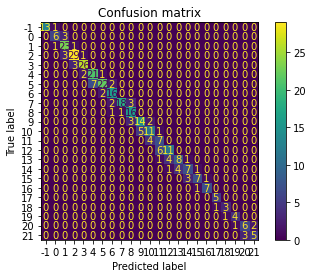

In [62]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, round_predict)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(-1, 22))

disp.plot()
plt.title("Confusion matrix")
plt.show()

In [80]:
threshold48 = 0.48
round_predict_lower_threshold48 = np.where(
    (predict % 1) > threshold48, np.ceil(predict), np.floor(predict)
).astype("int")

print("Round lower threshold = 0.48:")
check_predictions(y_test, round_predict_lower_threshold48)

Round lower threshold = 0.48:
Mean square error: 0.23
RMSE: 0.48



### With random split

In [20]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-08-07 21:12:25,212] A new study created in memory with name: no-name-d47ba457-7c8b-4e16-919d-0b7e6f0275ce
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.164372 + 0.0259736


feature_fraction, val_score: 0.164344:  14%|######4                                      | 1/7 [00:00<00:04,  1.22it/s]

Early stopping, best iteration is:
[99]	cv_agg's l2: 0.164344 + 0.0259071
[100]	cv_agg's l2: 0.192615 + 0.0409583


feature_fraction, val_score: 0.164344:  29%|############8                                | 2/7 [00:01<00:04,  1.16it/s]

Early stopping, best iteration is:
[99]	cv_agg's l2: 0.164344 + 0.0259071
[100]	cv_agg's l2: 0.181112 + 0.0407863


feature_fraction, val_score: 0.164344:  43%|###################2                         | 3/7 [00:02<00:03,  1.22it/s]

Early stopping, best iteration is:
[99]	cv_agg's l2: 0.164344 + 0.0259071
[100]	cv_agg's l2: 0.166328 + 0.0217212


feature_fraction, val_score: 0.164344:  57%|#########################7                   | 4/7 [00:03<00:02,  1.25it/s]

Early stopping, best iteration is:
[99]	cv_agg's l2: 0.164344 + 0.0259071
[100]	cv_agg's l2: 0.193393 + 0.0521645


feature_fraction, val_score: 0.164344:  71%|################################1            | 5/7 [00:04<00:01,  1.22it/s]

Early stopping, best iteration is:
[99]	cv_agg's l2: 0.164344 + 0.0259071
[100]	cv_agg's l2: 0.171143 + 0.0324049


feature_fraction, val_score: 0.164344:  86%|######################################5      | 6/7 [00:05<00:00,  1.17it/s]

Early stopping, best iteration is:
[99]	cv_agg's l2: 0.164344 + 0.0259071
[100]	cv_agg's l2: 0.164516 + 0.0237532
[200]	cv_agg's l2: 0.164344 + 0.0211735
Early stopping, best iteration is:
[147]	cv_agg's l2: 0.163729 + 0.0221522


num_leaves, val_score: 0.163729:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.164516 + 0.0237532
[200]	cv_agg's l2: 0.164344 + 0.0211735


num_leaves, val_score: 0.163729:   5%|##5                                               | 1/20 [00:01<00:22,  1.17s/it]

Early stopping, best iteration is:
[147]	cv_agg's l2: 0.163729 + 0.0221522
[100]	cv_agg's l2: 0.164516 + 0.0237532
[200]	cv_agg's l2: 0.164344 + 0.0211735


num_leaves, val_score: 0.163729:  10%|#####                                             | 2/20 [00:02<00:20,  1.15s/it]

Early stopping, best iteration is:
[147]	cv_agg's l2: 0.163729 + 0.0221522
[100]	cv_agg's l2: 0.164516 + 0.0237532
[200]	cv_agg's l2: 0.164344 + 0.0211735
Early stopping, best iteration is:
[147]	cv_agg's l2: 0.163729 + 0.0221522


num_leaves, val_score: 0.163729:  15%|#######5                                          | 3/20 [00:03<00:18,  1.11s/it]

[100]	cv_agg's l2: 0.164516 + 0.0237532
[200]	cv_agg's l2: 0.164344 + 0.0211735


num_leaves, val_score: 0.163729:  20%|##########                                        | 4/20 [00:04<00:17,  1.12s/it]

Early stopping, best iteration is:
[147]	cv_agg's l2: 0.163729 + 0.0221522
[100]	cv_agg's l2: 0.164516 + 0.0237532
[200]	cv_agg's l2: 0.164344 + 0.0211735
Early stopping, best iteration is:
[147]	cv_agg's l2: 0.163729 + 0.0221522


num_leaves, val_score: 0.163729:  25%|############5                                     | 5/20 [00:05<00:16,  1.09s/it]

[100]	cv_agg's l2: 0.164516 + 0.0237532
[200]	cv_agg's l2: 0.164344 + 0.0211735
Early stopping, best iteration is:
[147]	cv_agg's l2: 0.163729 + 0.0221522


num_leaves, val_score: 0.163729:  30%|###############                                   | 6/20 [00:06<00:15,  1.09s/it]

[100]	cv_agg's l2: 0.164516 + 0.0237532
[200]	cv_agg's l2: 0.164344 + 0.0211735


num_leaves, val_score: 0.163729:  35%|#################5                                | 7/20 [00:07<00:14,  1.12s/it]

Early stopping, best iteration is:
[147]	cv_agg's l2: 0.163729 + 0.0221522
[100]	cv_agg's l2: 0.164516 + 0.0237532
[200]	cv_agg's l2: 0.164344 + 0.0211735
Early stopping, best iteration is:
[147]	cv_agg's l2: 0.163729 + 0.0221522


num_leaves, val_score: 0.163729:  40%|####################                              | 8/20 [00:08<00:13,  1.10s/it]

[100]	cv_agg's l2: 0.164516 + 0.0237532
[200]	cv_agg's l2: 0.164344 + 0.0211735
Early stopping, best iteration is:
[147]	cv_agg's l2: 0.163729 + 0.0221522


num_leaves, val_score: 0.163729:  45%|######################5                           | 9/20 [00:09<00:12,  1.09s/it]

[100]	cv_agg's l2: 0.164516 + 0.0237532
[200]	cv_agg's l2: 0.164344 + 0.0211735


num_leaves, val_score: 0.163729:  50%|########################5                        | 10/20 [00:11<00:11,  1.13s/it]

Early stopping, best iteration is:
[147]	cv_agg's l2: 0.163729 + 0.0221522
[100]	cv_agg's l2: 0.166584 + 0.0260428


num_leaves, val_score: 0.163729:  55%|##########################9                      | 11/20 [00:11<00:09,  1.03s/it]

[200]	cv_agg's l2: 0.167552 + 0.0226359
Early stopping, best iteration is:
[147]	cv_agg's l2: 0.163729 + 0.0221522
[100]	cv_agg's l2: 0.164516 + 0.0237532
[200]	cv_agg's l2: 0.164344 + 0.0211735


num_leaves, val_score: 0.163729:  60%|#############################4                   | 12/20 [00:13<00:08,  1.06s/it]

Early stopping, best iteration is:
[147]	cv_agg's l2: 0.163729 + 0.0221522
[100]	cv_agg's l2: 0.164516 + 0.0237532
[200]	cv_agg's l2: 0.164344 + 0.0211735


num_leaves, val_score: 0.163729:  65%|###############################8                 | 13/20 [00:14<00:07,  1.13s/it]

Early stopping, best iteration is:
[147]	cv_agg's l2: 0.163729 + 0.0221522
[100]	cv_agg's l2: 0.164516 + 0.0237532
[200]	cv_agg's l2: 0.164344 + 0.0211735


num_leaves, val_score: 0.163729:  70%|##################################3              | 14/20 [00:15<00:06,  1.13s/it]

Early stopping, best iteration is:
[147]	cv_agg's l2: 0.163729 + 0.0221522
[100]	cv_agg's l2: 0.164516 + 0.0237532
[200]	cv_agg's l2: 0.164344 + 0.0211735


num_leaves, val_score: 0.163729:  75%|####################################7            | 15/20 [00:16<00:05,  1.14s/it]

Early stopping, best iteration is:
[147]	cv_agg's l2: 0.163729 + 0.0221522
[100]	cv_agg's l2: 0.164516 + 0.0237532
[200]	cv_agg's l2: 0.164344 + 0.0211735
Early stopping, best iteration is:
[147]	cv_agg's l2: 0.163729 + 0.0221522


num_leaves, val_score: 0.163729:  80%|#######################################2         | 16/20 [00:17<00:04,  1.16s/it]

[100]	cv_agg's l2: 0.164516 + 0.0237532
[200]	cv_agg's l2: 0.164344 + 0.0211735
Early stopping, best iteration is:
[147]	cv_agg's l2: 0.163729 + 0.0221522


num_leaves, val_score: 0.163729:  85%|#########################################6       | 17/20 [00:19<00:03,  1.17s/it]

[100]	cv_agg's l2: 0.164516 + 0.0237532
[200]	cv_agg's l2: 0.164344 + 0.0211735
Early stopping, best iteration is:
[147]	cv_agg's l2: 0.163729 + 0.0221522


num_leaves, val_score: 0.163729:  90%|############################################1    | 18/20 [00:20<00:02,  1.14s/it]

[100]	cv_agg's l2: 0.164516 + 0.0237532
[200]	cv_agg's l2: 0.164344 + 0.0211735


num_leaves, val_score: 0.163729:  95%|##############################################5  | 19/20 [00:21<00:01,  1.16s/it]

Early stopping, best iteration is:
[147]	cv_agg's l2: 0.163729 + 0.0221522
[100]	cv_agg's l2: 0.164516 + 0.0237532
[200]	cv_agg's l2: 0.164344 + 0.0211735


num_leaves, val_score: 0.163729: 100%|#################################################| 20/20 [00:22<00:00,  1.13s/it]


Early stopping, best iteration is:
[147]	cv_agg's l2: 0.163729 + 0.0221522


bagging, val_score: 0.163729:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.173858 + 0.0250545


bagging, val_score: 0.163729:  10%|#####3                                               | 1/10 [00:01<00:09,  1.03s/it]

[200]	cv_agg's l2: 0.169661 + 0.0207068
Early stopping, best iteration is:
[147]	cv_agg's l2: 0.163729 + 0.0221522
[100]	cv_agg's l2: 0.22027 + 0.0235855


bagging, val_score: 0.163729:  20%|##########6                                          | 2/10 [00:01<00:06,  1.28it/s]

[200]	cv_agg's l2: 0.207568 + 0.0160952
Early stopping, best iteration is:
[147]	cv_agg's l2: 0.163729 + 0.0221522
[100]	cv_agg's l2: 0.164873 + 0.024293
[200]	cv_agg's l2: 0.165522 + 0.0226412


bagging, val_score: 0.163729:  30%|###############9                                     | 3/10 [00:02<00:06,  1.07it/s]

Early stopping, best iteration is:
[147]	cv_agg's l2: 0.163729 + 0.0221522
[100]	cv_agg's l2: 0.191944 + 0.0212036


bagging, val_score: 0.163729:  40%|#####################2                               | 4/10 [00:03<00:05,  1.15it/s]

[200]	cv_agg's l2: 0.186915 + 0.0211361
Early stopping, best iteration is:
[147]	cv_agg's l2: 0.163729 + 0.0221522
[100]	cv_agg's l2: 0.174782 + 0.0257196


bagging, val_score: 0.163729:  40%|#####################2                               | 4/10 [00:04<00:05,  1.15it/s]

[200]	cv_agg's l2: 0.171844 + 0.0196971
Early stopping, best iteration is:
[147]	cv_agg's l2: 0.163729 + 0.0221522


bagging, val_score: 0.163729:  50%|##########################5                          | 5/10 [00:04<00:04,  1.10it/s]

[100]	cv_agg's l2: 0.165261 + 0.0217959
[200]	cv_agg's l2: 0.164375 + 0.0202689


bagging, val_score: 0.163729:  60%|###############################8                     | 6/10 [00:05<00:03,  1.03it/s]

Early stopping, best iteration is:
[147]	cv_agg's l2: 0.163729 + 0.0221522
[100]	cv_agg's l2: 0.181769 + 0.0208586


bagging, val_score: 0.163729:  70%|#####################################                | 7/10 [00:06<00:02,  1.03it/s]

[200]	cv_agg's l2: 0.174802 + 0.0171402
Early stopping, best iteration is:
[147]	cv_agg's l2: 0.163729 + 0.0221522
[100]	cv_agg's l2: 0.226347 + 0.0147052


bagging, val_score: 0.163729:  80%|##########################################4          | 8/10 [00:07<00:01,  1.12it/s]

[200]	cv_agg's l2: 0.214214 + 0.00838513
Early stopping, best iteration is:
[147]	cv_agg's l2: 0.163729 + 0.0221522
[100]	cv_agg's l2: 0.169663 + 0.0283837
[200]	cv_agg's l2: 0.166978 + 0.0237832


bagging, val_score: 0.163729:  90%|###############################################7     | 9/10 [00:08<00:00,  1.02it/s]

Early stopping, best iteration is:
[147]	cv_agg's l2: 0.163729 + 0.0221522
[100]	cv_agg's l2: 0.194709 + 0.0243024


bagging, val_score: 0.163729: 100%|####################################################| 10/10 [00:09<00:00,  1.08it/s]


[200]	cv_agg's l2: 0.187011 + 0.0232635
Early stopping, best iteration is:
[147]	cv_agg's l2: 0.163729 + 0.0221522


feature_fraction_stage2, val_score: 0.163729:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.166328 + 0.0217212


feature_fraction_stage2, val_score: 0.163729:   0%|                                              | 0/6 [00:01<?, ?it/s]

[200]	cv_agg's l2: 0.165723 + 0.021112
Early stopping, best iteration is:
[147]	cv_agg's l2: 0.163729 + 0.0221522


feature_fraction_stage2, val_score: 0.163729:  17%|######3                               | 1/6 [00:01<00:05,  1.14s/it]

[100]	cv_agg's l2: 0.164516 + 0.0237532
[200]	cv_agg's l2: 0.164344 + 0.0211735
Early stopping, best iteration is:
[147]	cv_agg's l2: 0.163729 + 0.0221522


feature_fraction_stage2, val_score: 0.163729:  33%|############6                         | 2/6 [00:02<00:04,  1.11s/it]

[100]	cv_agg's l2: 0.162143 + 0.021904


feature_fraction_stage2, val_score: 0.161635:  50%|###################                   | 3/6 [00:03<00:03,  1.04s/it]

[200]	cv_agg's l2: 0.164004 + 0.0193233
Early stopping, best iteration is:
[103]	cv_agg's l2: 0.161635 + 0.022089
[100]	cv_agg's l2: 0.164372 + 0.0259736


feature_fraction_stage2, val_score: 0.161635:  67%|#########################3            | 4/6 [00:04<00:02,  1.00s/it]

[200]	cv_agg's l2: 0.167231 + 0.0220458
Early stopping, best iteration is:
[103]	cv_agg's l2: 0.161635 + 0.022089
[100]	cv_agg's l2: 0.162143 + 0.021904


feature_fraction_stage2, val_score: 0.161635:  83%|###############################6      | 5/6 [00:05<00:00,  1.03it/s]

[200]	cv_agg's l2: 0.164004 + 0.0193233
Early stopping, best iteration is:
[103]	cv_agg's l2: 0.161635 + 0.022089
[100]	cv_agg's l2: 0.164516 + 0.0237532


feature_fraction_stage2, val_score: 0.161635: 100%|######################################| 6/6 [00:05<00:00,  1.00it/s]


[200]	cv_agg's l2: 0.164344 + 0.0211735
Early stopping, best iteration is:
[103]	cv_agg's l2: 0.161635 + 0.022089


regularization_factors, val_score: 0.161635:   5%|#9                                    | 1/20 [00:00<00:08,  2.22it/s]

[100]	cv_agg's l2: 0.181979 + 0.0296395
[200]	cv_agg's l2: 0.178001 + 0.0276952
Early stopping, best iteration is:
[103]	cv_agg's l2: 0.161635 + 0.022089
[100]	cv_agg's l2: 0.170349 + 0.0329694


regularization_factors, val_score: 0.161635:  10%|###8                                  | 2/20 [00:01<00:12,  1.39it/s]

[200]	cv_agg's l2: 0.167566 + 0.0292649
Early stopping, best iteration is:
[103]	cv_agg's l2: 0.161635 + 0.022089
[100]	cv_agg's l2: 0.163711 + 0.0223595


regularization_factors, val_score: 0.161635:  15%|#####7                                | 3/20 [00:02<00:13,  1.24it/s]

[200]	cv_agg's l2: 0.16376 + 0.0200827
Early stopping, best iteration is:
[103]	cv_agg's l2: 0.161635 + 0.022089
[100]	cv_agg's l2: 0.163712 + 0.0223598


regularization_factors, val_score: 0.161635:  20%|#######6                              | 4/20 [00:03<00:13,  1.16it/s]

[200]	cv_agg's l2: 0.164294 + 0.0210671
Early stopping, best iteration is:
[103]	cv_agg's l2: 0.161635 + 0.022089
[100]	cv_agg's l2: 0.162942 + 0.0209323


regularization_factors, val_score: 0.161635:  25%|#########5                            | 5/20 [00:04<00:13,  1.12it/s]

[200]	cv_agg's l2: 0.163295 + 0.0192346
Early stopping, best iteration is:
[103]	cv_agg's l2: 0.161635 + 0.022089
[100]	cv_agg's l2: 0.163712 + 0.0223598


regularization_factors, val_score: 0.161635:  30%|###########4                          | 6/20 [00:05<00:12,  1.08it/s]

[200]	cv_agg's l2: 0.164294 + 0.0210671
Early stopping, best iteration is:
[103]	cv_agg's l2: 0.161635 + 0.022089
[100]	cv_agg's l2: 0.163711 + 0.0223595


regularization_factors, val_score: 0.161635:  35%|#############3                        | 7/20 [00:06<00:12,  1.08it/s]

[200]	cv_agg's l2: 0.16376 + 0.0200827
Early stopping, best iteration is:
[103]	cv_agg's l2: 0.161635 + 0.022089
[100]	cv_agg's l2: 0.163154 + 0.0224012


regularization_factors, val_score: 0.161635:  40%|###############2                      | 8/20 [00:07<00:11,  1.08it/s]

[200]	cv_agg's l2: 0.162199 + 0.0204252
Early stopping, best iteration is:
[103]	cv_agg's l2: 0.161635 + 0.022089
[100]	cv_agg's l2: 0.163027 + 0.0224185


regularization_factors, val_score: 0.161635:  45%|#################1                    | 9/20 [00:07<00:09,  1.10it/s]

[200]	cv_agg's l2: 0.162953 + 0.0202788
Early stopping, best iteration is:
[103]	cv_agg's l2: 0.161635 + 0.022089
[100]	cv_agg's l2: 0.163154 + 0.0224012


regularization_factors, val_score: 0.161635:  50%|##################5                  | 10/20 [00:08<00:09,  1.06it/s]

[200]	cv_agg's l2: 0.162199 + 0.0204252
Early stopping, best iteration is:
[103]	cv_agg's l2: 0.161635 + 0.022089
[100]	cv_agg's l2: 0.162335 + 0.0206039


regularization_factors, val_score: 0.161635:  55%|####################3                | 11/20 [00:09<00:08,  1.08it/s]

[200]	cv_agg's l2: 0.164072 + 0.0181761
Early stopping, best iteration is:
[103]	cv_agg's l2: 0.161635 + 0.022089
[100]	cv_agg's l2: 0.16287 + 0.0231737


regularization_factors, val_score: 0.161635:  60%|######################2              | 12/20 [00:10<00:07,  1.06it/s]

[200]	cv_agg's l2: 0.162928 + 0.0221983
Early stopping, best iteration is:
[103]	cv_agg's l2: 0.161635 + 0.022089
[100]	cv_agg's l2: 0.160124 + 0.0235456


regularization_factors, val_score: 0.160065:  65%|########################             | 13/20 [00:11<00:06,  1.07it/s]

[200]	cv_agg's l2: 0.160447 + 0.0223649
Early stopping, best iteration is:
[106]	cv_agg's l2: 0.160065 + 0.0233963
[100]	cv_agg's l2: 0.161607 + 0.0226332


regularization_factors, val_score: 0.160065:  70%|#########################9           | 14/20 [00:12<00:05,  1.06it/s]

[200]	cv_agg's l2: 0.161395 + 0.0216067
Early stopping, best iteration is:
[106]	cv_agg's l2: 0.160065 + 0.0233963
[100]	cv_agg's l2: 0.16094 + 0.0244348
[200]	cv_agg's l2: 0.16015 + 0.0215829


regularization_factors, val_score: 0.159780:  75%|###########################7         | 15/20 [00:14<00:05,  1.16s/it]

[300]	cv_agg's l2: 0.160937 + 0.0209326
Early stopping, best iteration is:
[225]	cv_agg's l2: 0.15978 + 0.020583
[100]	cv_agg's l2: 0.160955 + 0.0261607
[200]	cv_agg's l2: 0.161634 + 0.0238762


regularization_factors, val_score: 0.159780:  80%|#############################6       | 16/20 [00:15<00:05,  1.27s/it]

[300]	cv_agg's l2: 0.161663 + 0.0237505
Early stopping, best iteration is:
[225]	cv_agg's l2: 0.15978 + 0.020583
[100]	cv_agg's l2: 0.164113 + 0.0251188
[200]	cv_agg's l2: 0.163967 + 0.0221378


regularization_factors, val_score: 0.159780:  85%|###############################4     | 17/20 [00:17<00:04,  1.39s/it]

[300]	cv_agg's l2: 0.164875 + 0.0224376
Early stopping, best iteration is:
[225]	cv_agg's l2: 0.15978 + 0.020583
[100]	cv_agg's l2: 0.163136 + 0.0260316
[200]	cv_agg's l2: 0.163146 + 0.0228552


regularization_factors, val_score: 0.159780:  90%|#################################3   | 18/20 [00:19<00:02,  1.44s/it]

[300]	cv_agg's l2: 0.163385 + 0.0227784
Early stopping, best iteration is:
[225]	cv_agg's l2: 0.15978 + 0.020583
[100]	cv_agg's l2: 0.162586 + 0.0230267
[200]	cv_agg's l2: 0.163536 + 0.0200856


regularization_factors, val_score: 0.159780:  95%|###################################1 | 19/20 [00:20<00:01,  1.45s/it]

[300]	cv_agg's l2: 0.163874 + 0.0196754
Early stopping, best iteration is:
[225]	cv_agg's l2: 0.15978 + 0.020583
[100]	cv_agg's l2: 0.162778 + 0.0247442
[200]	cv_agg's l2: 0.162991 + 0.0221179


regularization_factors, val_score: 0.159780: 100%|#####################################| 20/20 [00:22<00:00,  1.11s/it]


[300]	cv_agg's l2: 0.162792 + 0.0215861
Early stopping, best iteration is:
[225]	cv_agg's l2: 0.15978 + 0.020583


min_data_in_leaf, val_score: 0.159780:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.150362 + 0.0196666
[200]	cv_agg's l2: 0.148576 + 0.0190885


min_data_in_leaf, val_score: 0.148321:  20%|#########                                    | 1/5 [00:01<00:05,  1.45s/it]

Early stopping, best iteration is:
[173]	cv_agg's l2: 0.148321 + 0.0190289
[100]	cv_agg's l2: 0.649206 + 0.0656057


min_data_in_leaf, val_score: 0.148321:  40%|##################                           | 2/5 [00:01<00:02,  1.18it/s]

[200]	cv_agg's l2: 0.620637 + 0.0606739
Early stopping, best iteration is:
[173]	cv_agg's l2: 0.148321 + 0.0190289
[100]	cv_agg's l2: 0.145983 + 0.0221229


min_data_in_leaf, val_score: 0.145733:  60%|###########################                  | 3/5 [00:03<00:02,  1.02s/it]

[200]	cv_agg's l2: 0.146546 + 0.0219699
Early stopping, best iteration is:
[108]	cv_agg's l2: 0.145733 + 0.0224242
[100]	cv_agg's l2: 0.229967 + 0.0304937


min_data_in_leaf, val_score: 0.145733:  80%|####################################         | 4/5 [00:03<00:00,  1.19it/s]

[200]	cv_agg's l2: 0.219875 + 0.0269392
Early stopping, best iteration is:
[108]	cv_agg's l2: 0.145733 + 0.0224242
[100]	cv_agg's l2: 0.176448 + 0.0204178


min_data_in_leaf, val_score: 0.145733: 100%|#############################################| 5/5 [00:04<00:00,  1.12it/s]

[200]	cv_agg's l2: 0.172079 + 0.0188297
Early stopping, best iteration is:
[108]	cv_agg's l2: 0.145733 + 0.0224242


In [21]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.14573322235495723
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 0.0073293047286806115
    lambda_l2: 0.011928864459463118
    num_leaves: 31
    feature_fraction: 0.484
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 10


In [22]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

y_pred_random_split = lgb_tuned.predict(X_test_random_split)

mse = mean_squared_error(y_test_random_split, y_pred_random_split)
rmse = mean_squared_error(y_test_random_split, y_pred_random_split, squared=False)
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

MSE: 0.12
RMSE: 0.34


#### Rounded results

In [23]:
predict = lgb_tuned.predict(X_test_random_split)
round_predict = np.round(predict).astype("int")
round_predict = np.where(round_predict > 20, 21, round_predict)
threshold = 0.33
round_predict_lower_threshold = np.where(
    (predict % 1) > threshold, np.ceil(predict), np.floor(predict)
).astype("int")

In [24]:
def check_predictions(y, y_pred):
    print(f"Mean square error: {mean_squared_error(y, y_pred):.2f}")
    print(f"RMSE: {mean_squared_error(y, y_pred, squared=False):.2f}")
    print()

In [25]:
print("Normal:")
check_predictions(y_test_random_split, predict)

print("Round:")
check_predictions(y_test_random_split, round_predict)

print("Round lower threshold:")
check_predictions(y_test_random_split, round_predict_lower_threshold)

Normal:
Mean square error: 0.12
RMSE: 0.34

Round:
Mean square error: 0.13
RMSE: 0.36

Round more up:
Mean square error: 0.17
RMSE: 0.41



Lower threshold is worse here

#### Confusion matrix

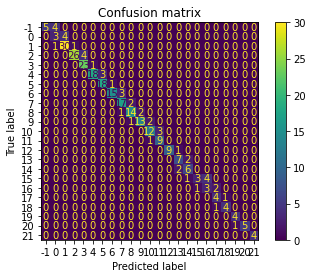

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_random_split, round_predict_lower_threshold)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(-1, 22))

disp.plot()
plt.title("Confusion matrix")
plt.show()

In [27]:
# save model to file
# gbm.save_model('model.txt')